### Segment and group

In [1]:
import torch
from PIL import Image 
import numpy as np

import matplotlib.pyplot as plt
import math
import cv2

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

from sklearn.cluster import KMeans, DBSCAN

import warnings
warnings.filterwarnings('ignore')

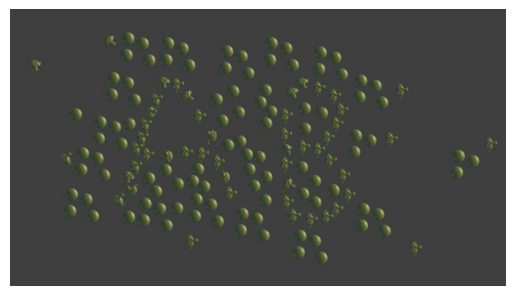

In [2]:
input_img = Image.open('../data/photo_5395381481544738290_y.jpg')
plt.imshow(input_img)
plt.axis('off')
plt.show()

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = '<path_to_>/sam_vit_h_4b8939.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(np.array(input_img))

In [4]:
len(masks)

141

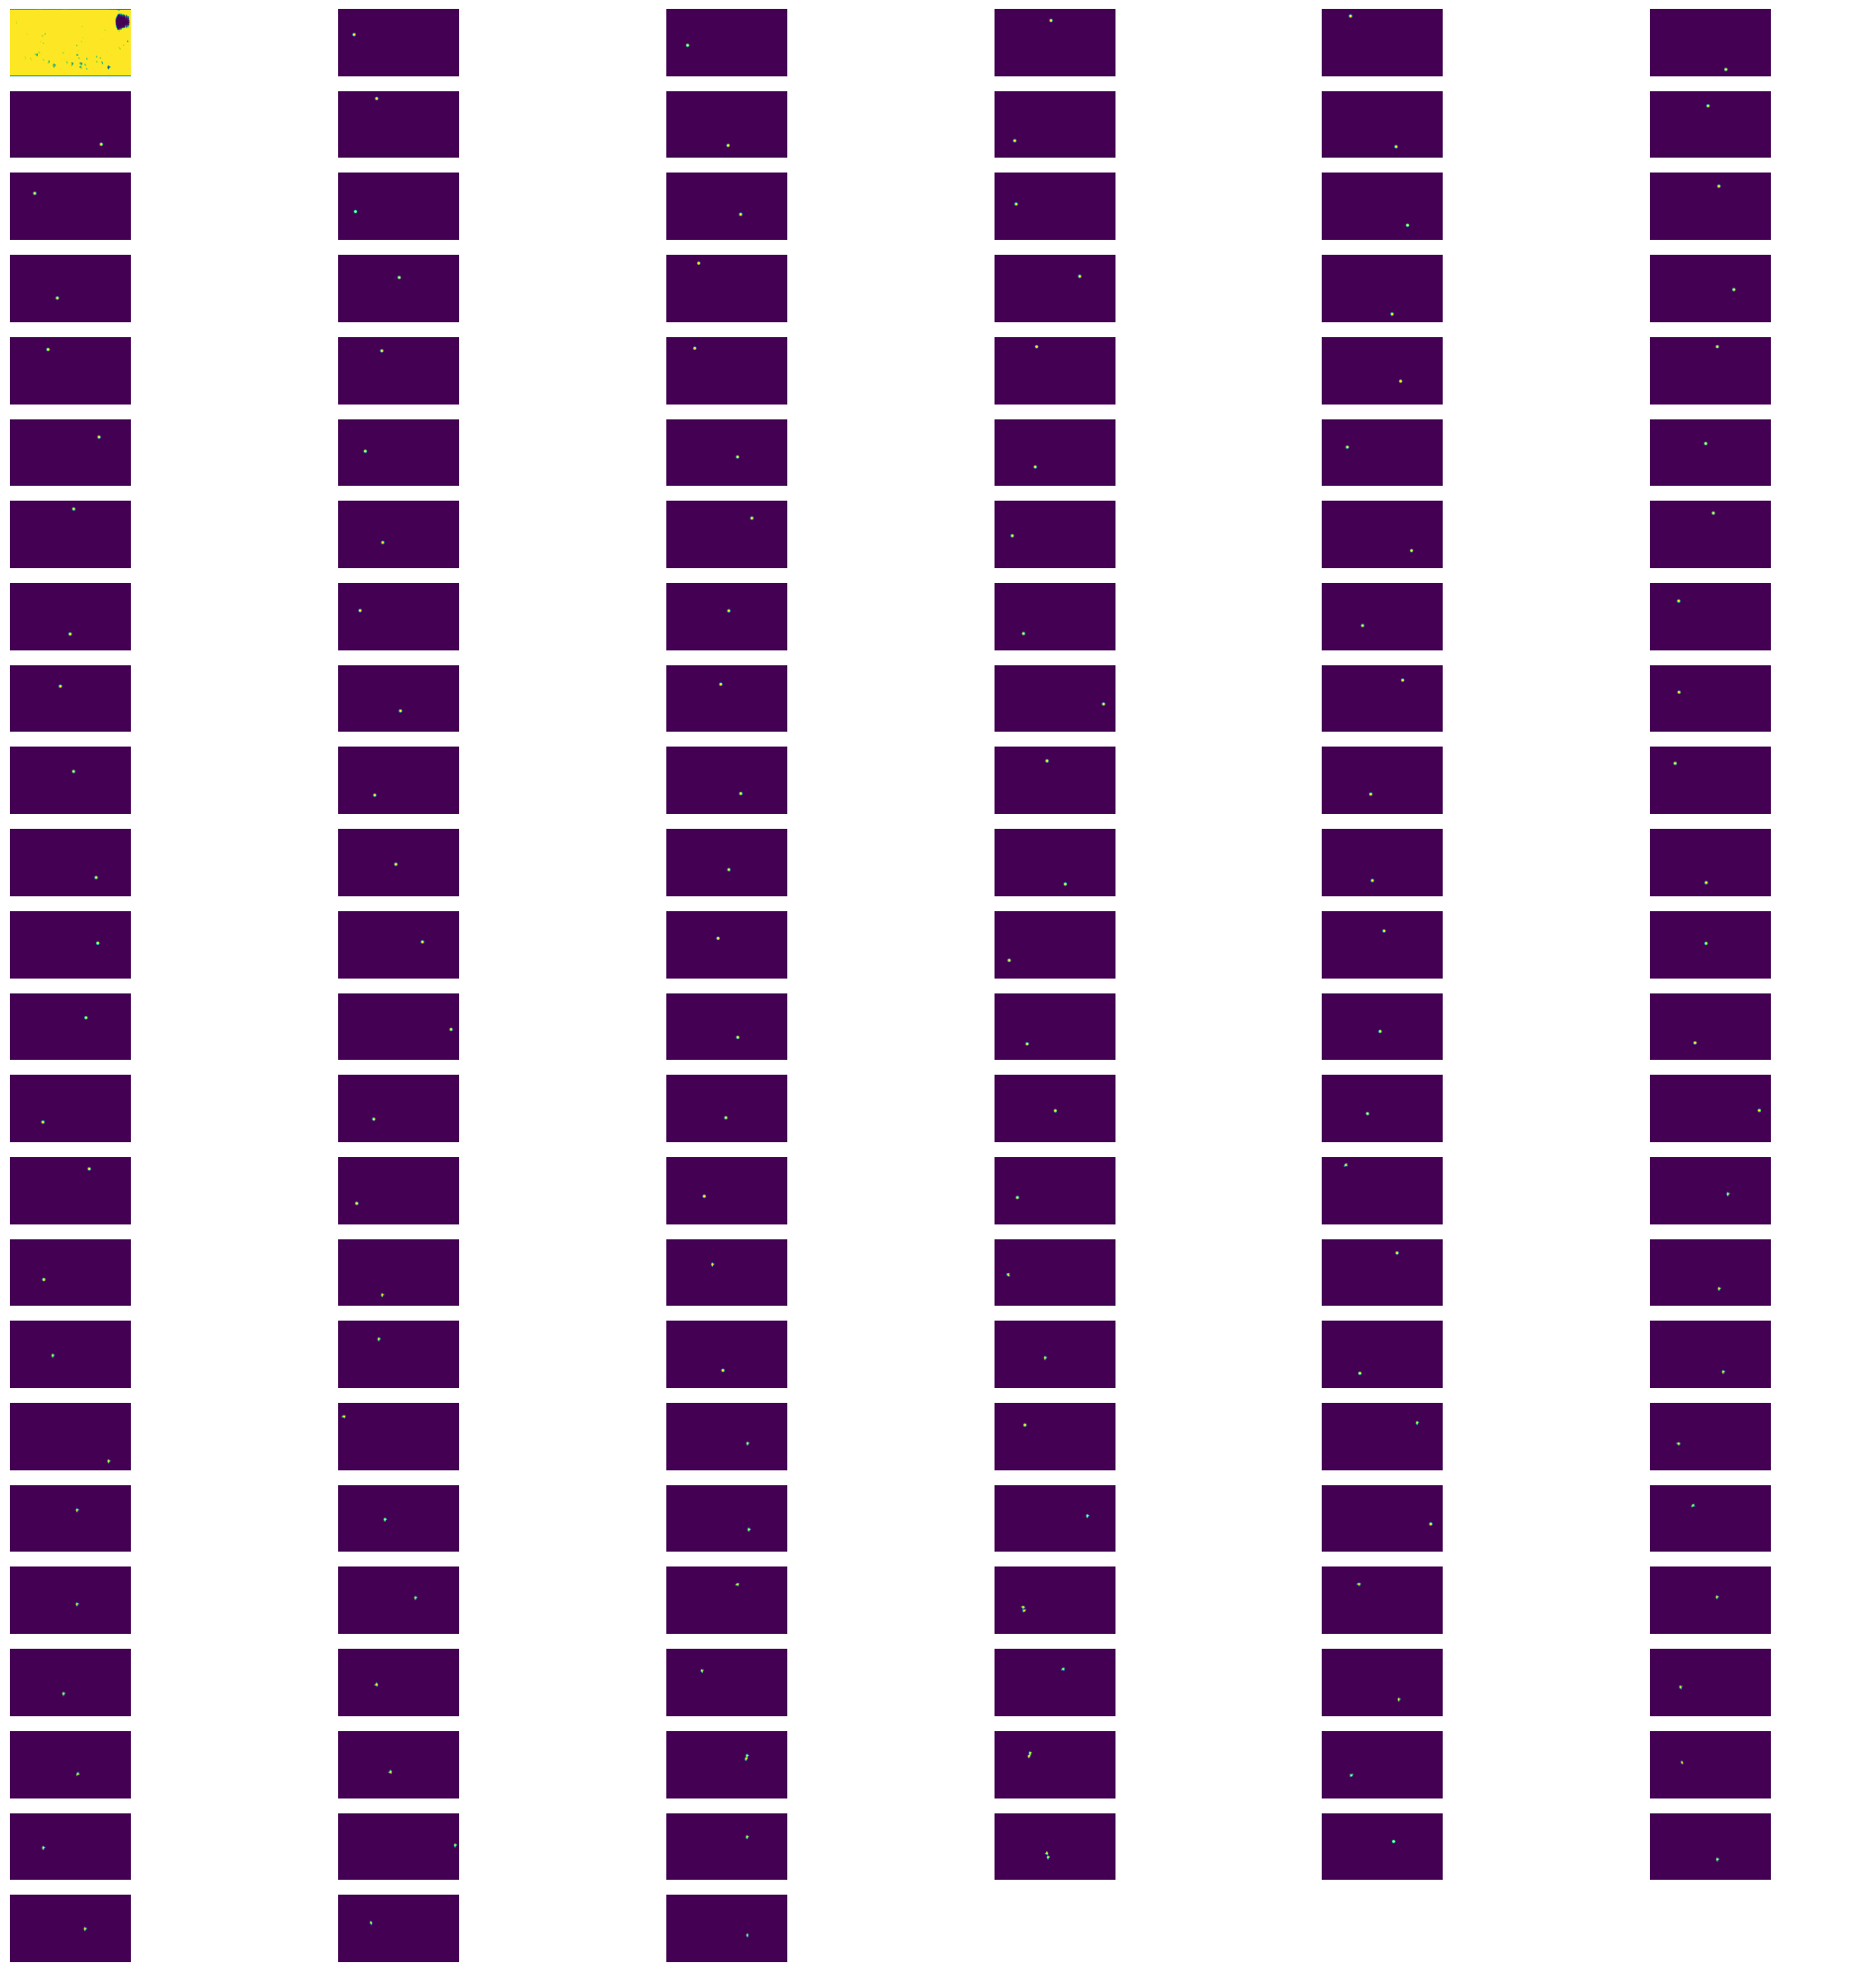

In [5]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for i in range(rows):
    for j in range(cols):
        if index < n:
            axes[i][j].imshow(masks[index]['segmentation'][:,:, None])
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [6]:
np.random.seed(0)
def show_anns(anns):
    colors = []
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        colors.append(color_mask)
        img[m] = color_mask
    ax.imshow(img)
    return img, colors

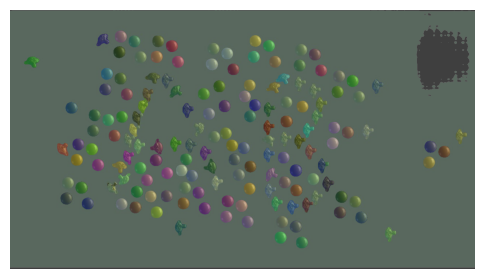

In [7]:
plt.figure(figsize=(6,12))
plt.imshow(np.array(input_img))
colored_img, colors = show_anns(masks)
plt.axis('off')
plt.show() 

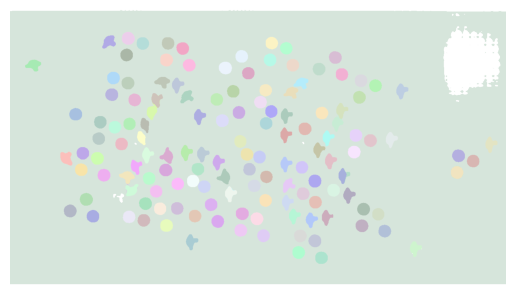

Number of colors 141


In [8]:
plt.imshow(colored_img)
plt.axis('off')
plt.show()
print("Number of colors", len(colors))

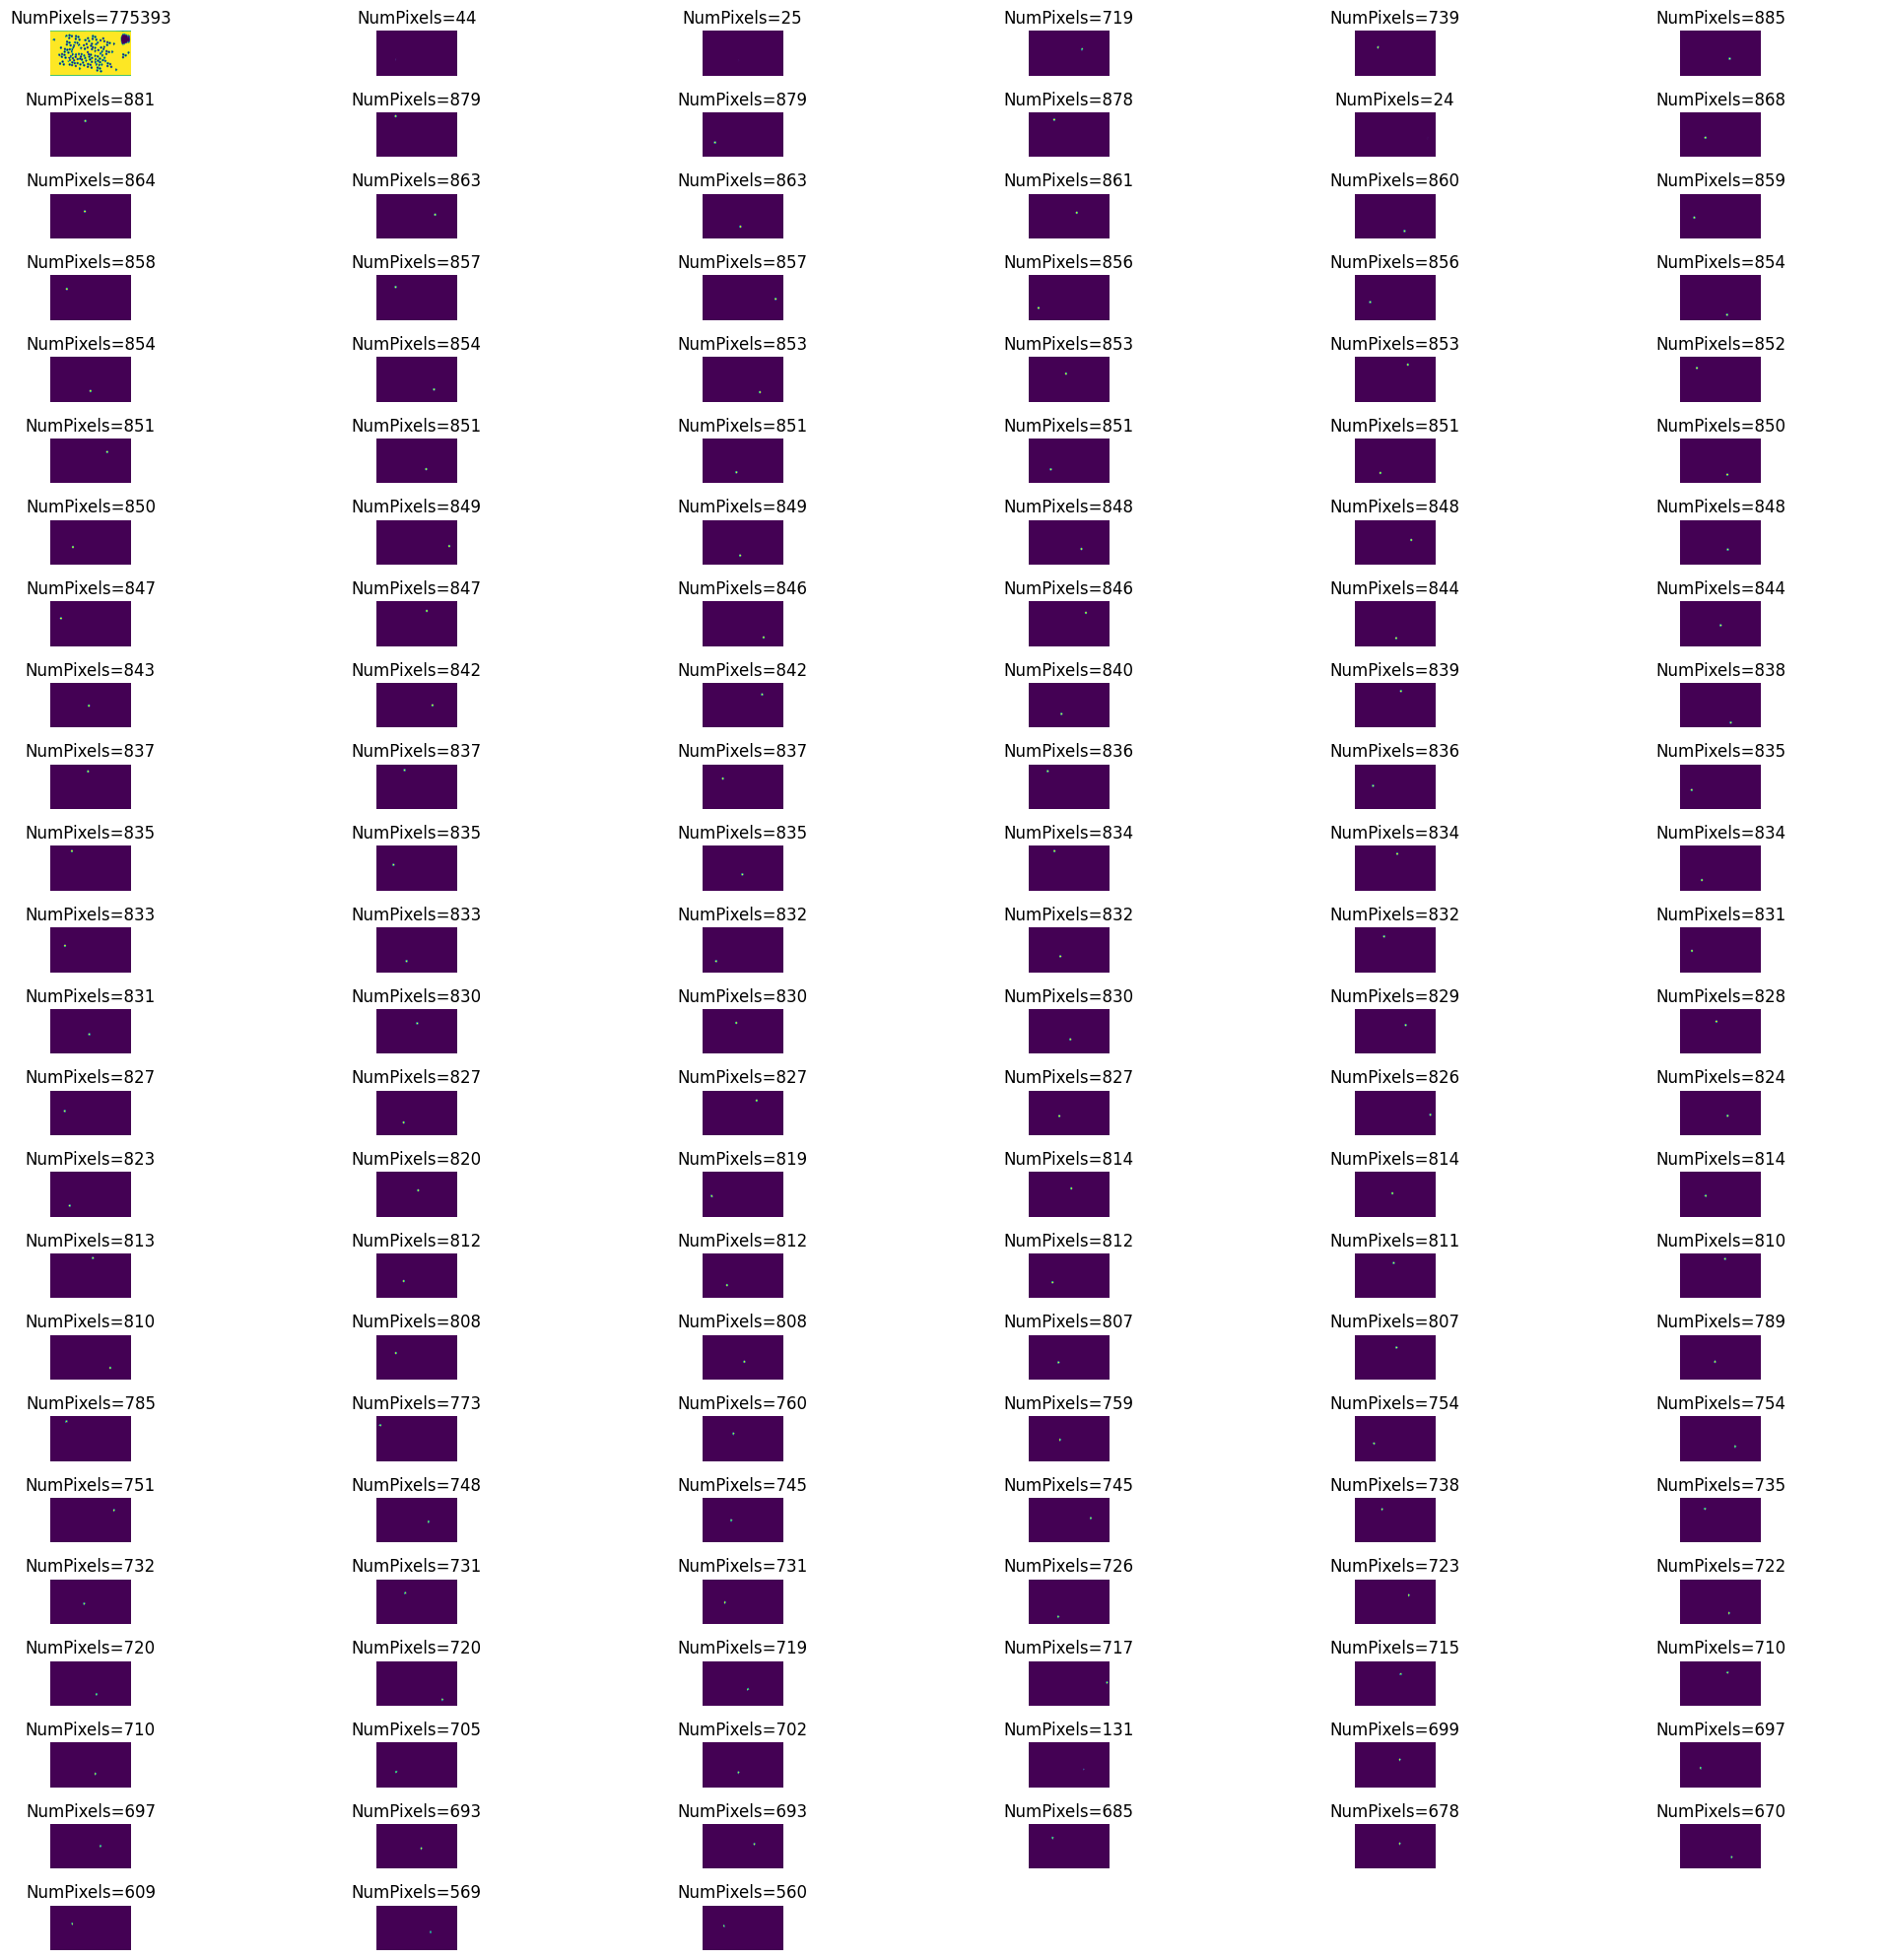

In [9]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            new_mask = (colored_img == colors[index]).all(axis=-1)
            axes[i][j].imshow(new_mask)
            axes[i][j].set_title(f'NumPixels={np.sum(new_mask)}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [10]:
np.array(input_img).shape[0] *  np.array(input_img).shape[1] * 0.0005

456.96000000000004

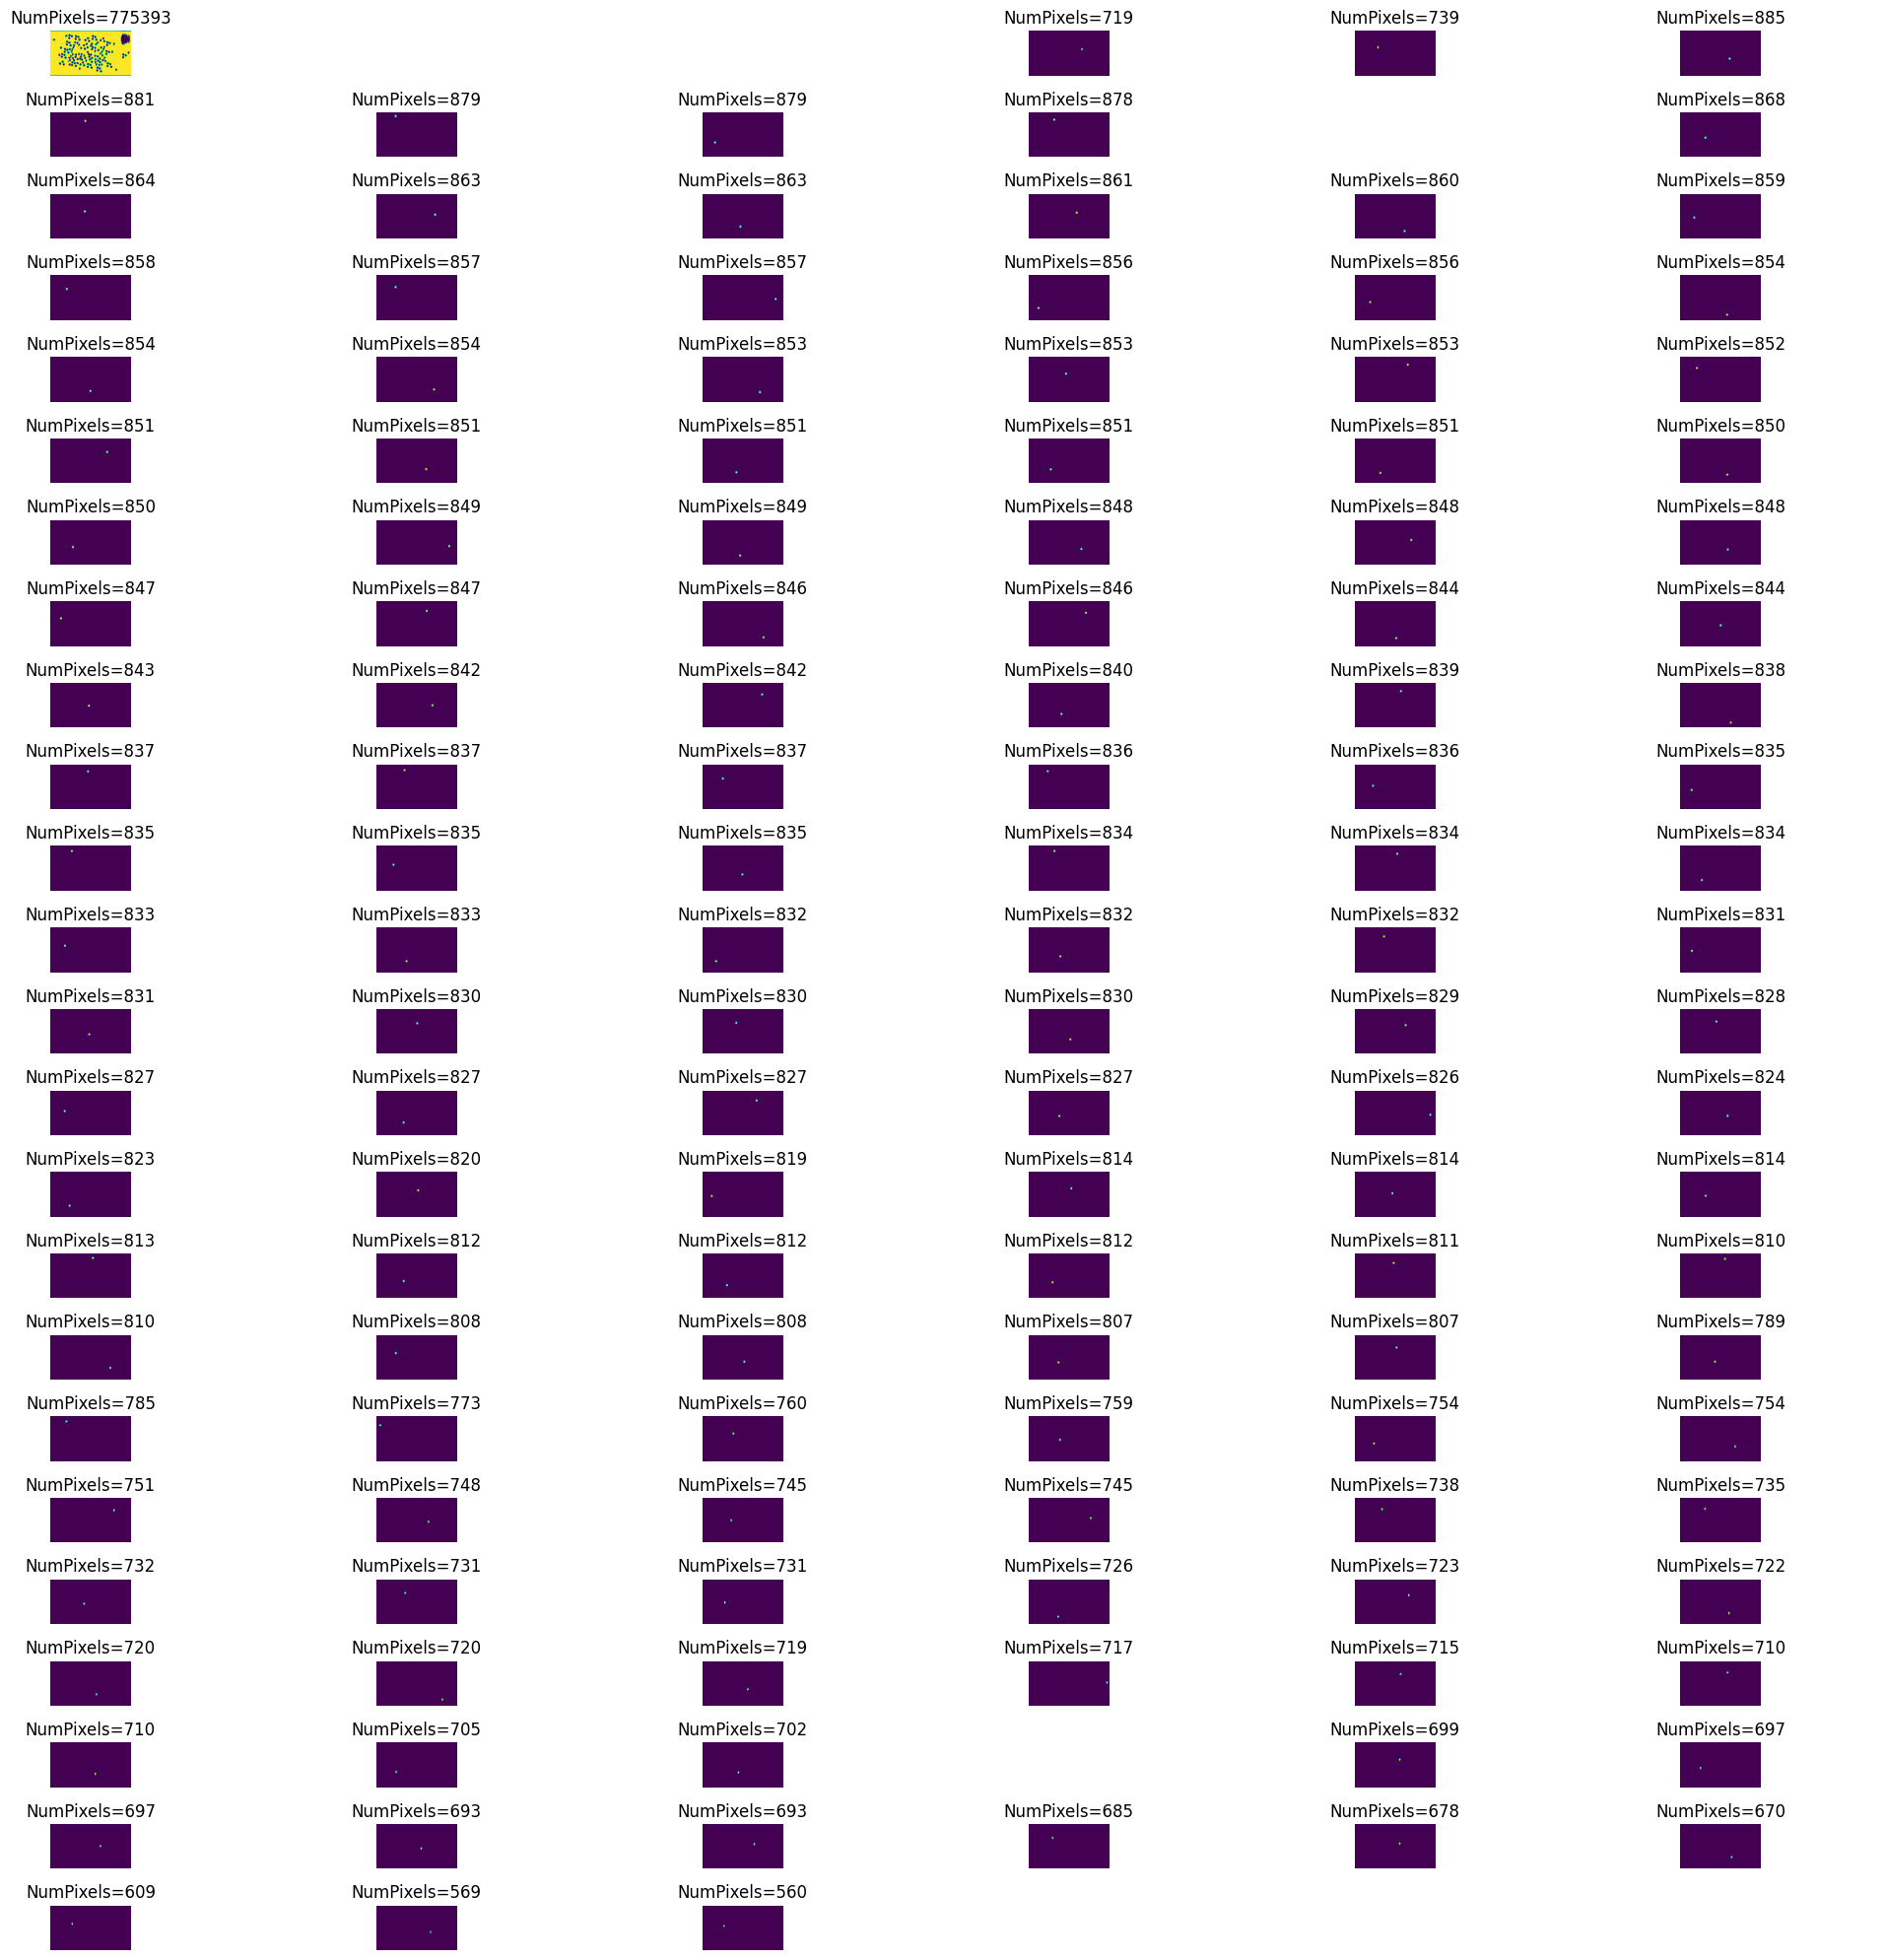

In [11]:
n = len(masks)
cols = 6
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20,20))
index = 0

new_masks_list = []
threshold = 0.0005

for i in range(len(axes)):
    for j in range(len(axes[0])):
        if index < n:
            new_mask = (colored_img == colors[index]).all(axis=-1)
            if np.sum(new_mask) >= colored_img.shape[0] * colored_img.shape[1] * threshold:
                new_masks_list.append(new_mask)
                axes[i][j].imshow(new_mask)
                axes[i][j].set_title(f'NumPixels={np.sum(new_mask)}')
            axes[i][j].axis('off')
            index += 1
        else:
            axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [12]:
new_masks_list = new_masks_list[1:]

After the set of masks is detected, the proposed approach is to represent each mask with a vector that describes its characteristics, and then implement clustering in this representation space to detect two classes. The proposed representation, which seems reasonable, is using cv2.HuMoments to measure the shape of the mask, and the clustering method will be KMeans.

In [13]:
huMoments_list = []
for i in range(len(new_masks_list)):
    moments = cv2.moments(new_masks_list[i].astype(np.uint8)) 
    huMoments = cv2.HuMoments(moments)
    huMoments_list.append(huMoments.squeeze())

In [14]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")

In [15]:
kmeans_output = kmeans.fit_predict(huMoments_list)
kmeans_output

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

In [16]:
mask1 = []
for i in range(len(huMoments_list)):
    if kmeans_output[i] == 1:
        mask1.append(new_masks_list[i])

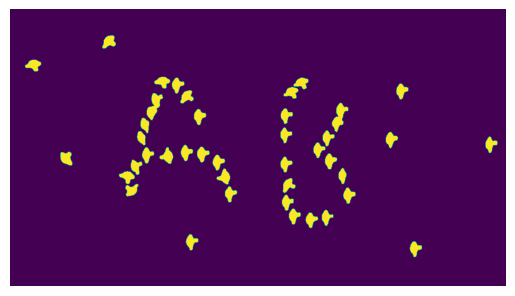

In [17]:
plt.imshow(sum(mask1))
plt.axis('off')
plt.show()

Now the idea is to analyze the distances between the detected objects in class 1. We want to color the letters formed from the nearest objects while ignoring outliers. A reasonable algorithm to implement this idea is DBSCAN clustering. When using DBSCAN, each mask is represented as a pair of coordinates that indicate the center of the mask

In [18]:
def find_center_of_mask(mask):
    m, n = mask.shape
    x_indices, y_indices = np.nonzero(mask)
    return np.array([np.mean(x_indices), np.mean(y_indices)])

In [19]:
m, n = mask1[0].shape
eps=100
centers = [find_center_of_mask(mask) for mask in mask1]
    
dbscan = DBSCAN(eps=100, min_samples=2)
# selected epsilon in such a way that there are 2 clusters and some outlier elements
clusters = dbscan.fit_predict(centers)
print(clusters)

selected_centers = np.array(centers)[clusters >= 0]

new_mask_lst = [np.linalg.norm(np.indices((m, n)).transpose(1,2,0) - \
                               cen, axis=-1) < eps / 2 for cen in selected_centers]


[ 0  1 -1  1  1 -1 -1  1  1  1  0 -1  0  1 -1  1  1  1  1  1 -1  0  0  0
 -1  0 -1  0  0  0  1  1  0  1  0  0  0  1  0  0  1  0  1]


Finally color the area inside the overlapping circles around the centers of the clustered masks

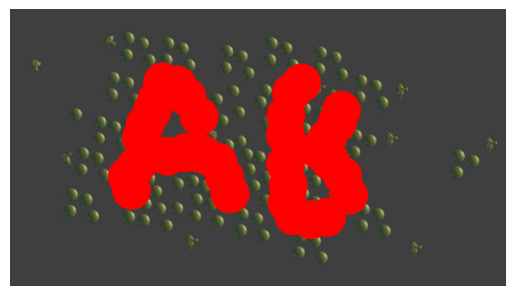

In [20]:
RED = [255, 0, 0]
mask = sum(new_mask_lst)
image = np.array(input_img).copy()
image[mask > 0] = np.array(RED) 

plt.imshow(image)
plt.axis('off')
plt.show()

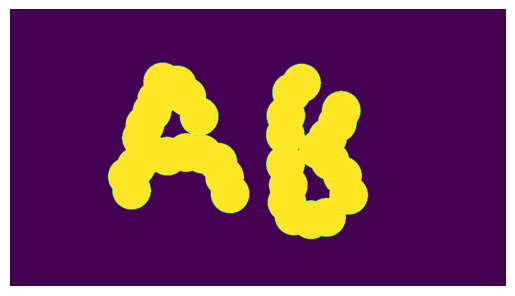

In [21]:
mask = sum(new_mask_lst) > 0
plt.imshow(mask)
plt.axis('off')
plt.show()